<a href="https://colab.research.google.com/github/princesinha24/abc/blob/master/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from torchsummary import summary
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import os
import math
import cv2

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        return torch.cat([x, out], 1)

In [ ]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(BottleneckBlock, self).__init__()
        inter_planes = out_planes * 4
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, inter_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(inter_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(inter_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu1(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        out = self.conv2(self.relu2(self.bn2(out)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        return torch.cat([x, out], 1)

In [ ]:
class TransitionBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(TransitionBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.droprate = dropRate
        self.avg_pool=nn.AvgPool2d(kernel_size=2, stride=2)
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        return self.avg_pool(out)

In [ ]:
class DenseBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, growth_rate, block, dropRate=0.0):
        super(DenseBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, growth_rate, nb_layers, dropRate)
    def _make_layer(self, block, in_planes, growth_rate, nb_layers, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(in_planes+i*growth_rate, growth_rate, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

In [ ]:
class DenseNet(nn.Module):
    def __init__(self, num_classes=4, growth_rate=32,
                 reduction=0.5, bottleneck=True, dropRate=0.0):
        super(DenseNet, self).__init__()
        in_planes = 64
        if bottleneck == True:
            block = BottleneckBlock
        else:
            block = BasicBlock
        # 1st conv before any dense block
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2,
                                padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        # 1st block
        self.block1 = DenseBlock(6, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+6*growth_rate)
        self.trans1 = TransitionBlock(in_planes, in_planes//2, dropRate=dropRate)
        in_planes = int(math.floor(in_planes*reduction))
        
        # 2nd block
        self.block2 = DenseBlock(12, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+12*growth_rate)
        self.trans2 = TransitionBlock(in_planes, in_planes//2, dropRate=dropRate)
        in_planes = in_planes//2
        
        # 3rd block
        self.block3 = DenseBlock(24, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+24*growth_rate)
        self.trans3 = TransitionBlock(in_planes, in_planes//2, dropRate=dropRate)
        in_planes = in_planes//2
       
        #4th block
        self.block4 = DenseBlock(16, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+16*growth_rate)
        
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.avg_pool=nn.AvgPool2d(kernel_size=7, stride=1)
        self.fc1 = nn.Linear(in_planes, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.in_planes = in_planes
    def forward(self, x):
        out = self.layer1(x)
        out = self.trans1(self.block1(out))
        out = self.trans2(self.block2(out))
        out = self.trans3(self.block3(out))
        out = self.block4(out)
        out = self.relu(self.bn1(out))
        out = self.avg_pool(out)
        out = out.view(-1, self.in_planes)
        out=  self.fc1(out)
        return self.fc2(out)

In [ ]:
model = DenseNet().to(device)
summary(model,(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]           8,192
       BatchNorm2d-8          [-1, 128, 56, 56]             256
              ReLU-9          [-1, 128, 56, 56]               0
           Conv2d-10           [-1, 32, 56, 56]          36,864
  BottleneckBlock-11           [-1, 96, 56, 56]               0
      BatchNorm2d-12           [-1, 96, 56, 56]             192
             ReLU-13           [-1, 96, 56, 56]               0
           Conv2d-14          [-1, 128,

In [ ]:
!pip install pkbar
import pkbar

In [ ]:
batch_size= 32
device = 'cuda'
num_classes= 4
input_shape=(3,224,224)
learning_rate=0.001
num_epochs= 40
load_model=True 

In [ ]:
Loss= nn.CrossEntropyLoss()
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
main_path= 'drive/MyDrive/KMC Dataset'
train_dir= os.path.join(main_path,'Training')
test_dir= os.path.join(main_path,'Test')
val_dir= os.path.join(main_path,'Validation')

check_pt_file= os.path.join(main_path, 'AlexNet.pth.tar')

print(os.listdir(main_path))
print(os.listdir(train_dir))
print(os.listdir(test_dir))
print(os.listdir(val_dir))

['Training', 'Validation', 'Test', 'ResNet50_Checkpoint_1.pth.tar', 'ResNet50.ipynb', 'AlexNet.ipynb', 'DenseNet.ipynb']
['grade1', 'grade3', 'grade2', 'grade0']
['grade1', 'grade0', 'grade2', 'grade3']
['grade2', 'grade1', 'grade0', 'grade3']


In [ ]:
train_data= datasets.ImageFolder(train_dir, transform= transforms.ToTensor())
test_data= datasets.ImageFolder(test_dir, transform= transforms.ToTensor())
val_data= datasets.ImageFolder(val_dir, transform= transforms.ToTensor())

In [ ]:
train_loader= DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader= DataLoader(test_data, batch_size=batch_size, shuffle=True)
val_loader= DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [ ]:
train_data.class_to_idx

{'grade0': 0, 'grade1': 1, 'grade2': 2, 'grade3': 3}

In [ ]:
def save_checkpoint(state,filename="drive/MyDrive/KMC Dataset/AlexNet_checkpoint.pth.tar"):
  torch.save(state,filename)
  print("save checkpoint")
def load_checkpoint(checkpoint):
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  print("load check point")

In [ ]:
if load_model:
  load_checkpoint(torch.load("drive/MyDrive/KMC Dataset/AlexNet_checkpoint.pth.tar"))

load check point


In [ ]:
def check_accuracy(scores, targets):

  num_correct=0
  num_samples=0
  _, predictions= scores.max(1)
  num_correct+= (predictions== targets).sum()
  num_samples= predictions.size(0)

  return num_correct/num_samples

In [ ]:
train_per_epoch= len(train_loader)
val_per_epoch= len(val_loader)
min_loss= math.inf
min_loss



for epoch in range(num_epochs):
  train_losses=[]
### TRAINING

  kbar_train= pkbar.Kbar(target= train_per_epoch, epoch=epoch, num_epochs=num_epochs)

  train_loop= enumerate(train_loader)
  val_loop= enumerate(val_loader)
  for batch_idx, (data,targets) in train_loop:

    model.train()

    data= data.to(device=device)
    targets= targets.to(device=device)

    # FORWARD PROP

    scores= model(data)
    train_loss= Loss(scores, targets)
    train_losses.append(train_loss.item())

    # BACKWARD PROP
    optimizer.zero_grad()
    train_loss.backward()

    optimizer.step()

    train_acc= check_accuracy(scores,targets)

    kbar_train.update(batch_idx, values=[("loss", train_loss.item()), ("accuracy", train_acc.item())])

  kbar_train.update(train_per_epoch, values=None)
### VALIDATION

  kbar_val= pkbar.Kbar(target= val_per_epoch, epoch=epoch, num_epochs=num_epochs)


  for batch_idx, (data, targets) in val_loop:

    val_losses=[]
    model.eval()

    
    data= data.to(device=device)
    targets= targets.to(device=device)
    scores= model(data)
    val_loss= Loss(scores, targets)
    val_losses.append(val_loss.item())
    val_acc= check_accuracy(scores,targets)

    kbar_val.update(batch_idx, values=[("val_loss", val_loss.item()), ("val_accuracy", val_acc.item())])

  if np.mean(val_losses)<min_loss:
    min_loss= val_loss.item()
    print('\nImproved validation loss: {:.4f}'.format(val_loss.item()))
    print('Saving the model to {}\n'.format(check_pt_file))
    checkpoint={'state_dict':model.state_dict(),'optimizer':optimizer.state_dict()}
    save_checkpoint(checkpoint)
    
  kbar_val.update(val_per_epoch, values=None)

Epoch: 1/40
83/83 [==============================] - 40s 488ms/step - loss: 0.0670 - accuracy: 0.9729
Epoch: 1/40
8/9 [=========================>....] - ETA: 0s - val_loss: 0.7799 - val_accuracy: 0.8698
Improved validation loss: 0.5615
Saving the model to drive/MyDrive/KMC Dataset/AlexNet.pth.tar

save checkpoint
9/9 [==============================] - 3s 280ms/step - val_loss: 0.7799 - val_accuracy: 0.8698
Epoch: 2/40
83/83 [==============================] - 41s 493ms/step - loss: 0.0279 - accuracy: 0.9909
Epoch: 2/40
9/9 [==============================] - 2s 229ms/step - val_loss: 2.5068 - val_accuracy: 0.8164
Epoch: 3/40
83/83 [==============================] - 41s 494ms/step - loss: 0.0432 - accuracy: 0.9842
Epoch: 3/40
9/9 [==============================] - 2s 232ms/step - val_loss: 2.4799 - val_accuracy: 0.6562
Epoch: 4/40
83/83 [==============================] - 41s 498ms/step - loss: 0.0557 - accuracy: 0.9812
Epoch: 4/40
9/9 [==============================] - 2s 237ms/step - val

In [ ]:
#check accuracy and create confussion matrix
def confusion(loader, model):
    #confusion matrix
    con=np.zeros([4,4],dtype=np.long)
    print("Checking accuracy on data")

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            #print (predictions,y)
            for i in range(y.size(0)):
              con[predictions[i]][y[i]]+=1
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        print (con)
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )

    model.train()
    return con

In [ ]:
con_train=confusion(train_loader, model)
con_test=confusion(test_loader, model)

Checking accuracy on data
[[672   0   0   0]
 [  0 627  12   0]
 [  0  13 658   0]
 [  0   0   0 665]]
Got 2622 / 2647 with accuracy 99.06
Checking accuracy on data
[[69  0  0  0]
 [ 1 74 18  0]
 [ 0  6 62  1]
 [ 0  0  0 49]]
Got 254 / 280 with accuracy 90.71


In [ ]:
def precision_recall_f1(confusion_matrix):
  num_classes= confusion_matrix.shape[0]
  precision= np.zeros(num_classes, np.float64)
  recall= np.zeros(num_classes, np.float64)
  f1= np.zeros(num_classes, np.float64)

  for i in range(num_classes):
    precision[i]= confusion_matrix[i,i]/np.sum(confusion_matrix[i])
    recall[i]= confusion_matrix[i,i]/np.sum(confusion_matrix[:,i])
    f1[i]= 2*precision[i]*recall[i]/(precision[i]+recall[i])

  return precision, recall, f1

In [ ]:
precision, recall, f1= precision_recall_f1(con_test)
print(precision,recall,f1,sep='\n')

[1.         0.79569892 0.89855072 1.        ]
[0.98571429 0.925      0.775      0.98      ]
[0.99280576 0.85549133 0.83221477 0.98989899]


In [ ]:
print("Precision:",np.mean(precision))
print("Recall:",np.mean(recall))
print("F1 score:",np.mean(f1))

Precision: 0.9235624123422159
Recall: 0.9164285714285715
F1 score: 0.9176027099687784


Expected 2 Got 2 | Expected 1 Got 1 | Expected 1 Got 1 | Expected 3 Got 3 | Expected 2 Got 2 | Expected 1 Got 1 | Expected 2 Got 2 | Expected 3 Got 3 | Expected 2 Got 2 | Expected 0 Got 0 | Expected 1 Got 1 | Expected 2 Got 2 | Expected 2 Got 2 | Expected 1 Got 1 | Expected 1 Got 2 | Expected 2 Got 1 | Expected 1 Got 1 | Expected 1 Got 1 | Expected 2 Got 1 | Expected 2 Got 2 | 

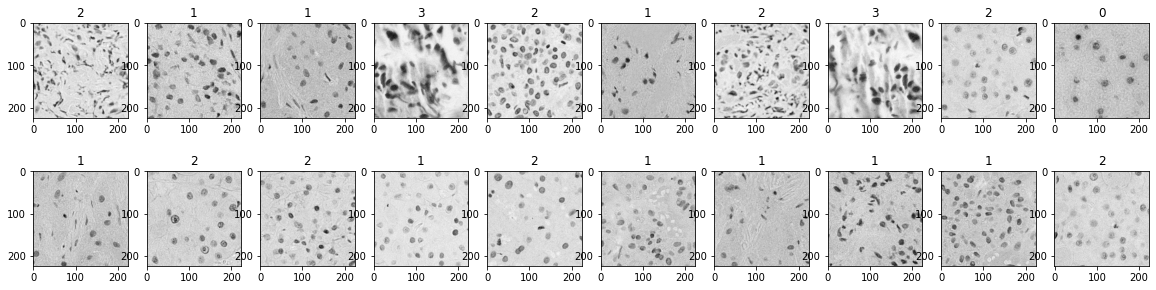

In [ ]:
iterator2= iter(test_loader)
t2 = next(iterator2)
images, labels= t2

model.eval()
scores= model(images.to(device=device))

plt.figure(figsize=(20,5))
for r in range(0,20):
    plt.subplot(2,10,r+1)
    f= plt.imshow(images[r,0],cmap='gray')
    plt.title(int((scores.max(1))[1][r]))
    print('Expected',int(labels[r]),'Got',int((scores.max(1))[1][r]),end=' | ')
plt.show()